<center><H1>An Introduction to the Python-ARM Radar Toolkit</H1></center>

The Python ARM Radar Toolkit, Py-ART, is a Python module containing a collection of weather radar algorithms and utilities. Py-ART is partly funded by and used by the Atmospheric Radiation Measurement (ARM) Climate Research Facility for working with data from a number of its precipitation and cloud radars, but has been designed so that it can be used by others in the radar and atmospheric communities to examine, processes, and analyze data from many types of weather radars.

In [1]:
#first, import Py-ART
import pyart


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [2]:
#and some other things we need
from matplotlib import pyplot as plt
import os
from netCDF4 import num2date
import cartopy
import numpy as np

#and set images to appear inline
%matplotlib inline

Py-ART has several modules
-------------------------
1) io: io operations

2) Correct: corrections in antenna coordinates

3) Retrieve: Retrievals in both antenna and Cartesian Coordinates

4) Map: Mapping/gridding to a cartesian coordinate space

5) Graph: Plotting both radial and Cartesian data

Lets look at an example from the ARM C-Band Scanning ARM Precipitation Radar, C-SAPR

![ARM C-SAPR](images/csapr.jpeg)

In [3]:
#first, get a string with the full pathname 
home_dir = os.path.expanduser('~')
filename = '110635.mdv'
full_file_name = os.path.join(home_dir, filename)

In [4]:
#Read the data into the Py-ART Common Data Model
radar = pyart.io.read(full_file_name)

Py-ART has a data model that looks very similar to CF-Radial. It makes heavy use of dictionaries.. If in doubt, always remember *the data is in 'data'*

In [5]:
#field data is in fields
print(radar.fields.keys())

dict_keys(['reflectivity', 'cross_correlation_ratio', 'specific_differential_phase', 'normalized_coherent_power', 'differential_reflectivity', 'differential_phase', 'spectrum_width', 'velocity'])


In [6]:
#there are several dimensional fields
print('Our radar has ', radar.range['data'].shape, ' gates')
print('Our radar has ', radar.azimuth['data'].shape, ' gates')
print('Units of time is ', radar.time['units'])
print('Collection started at ', num2date(radar.time['data'][0],radar.time['units'] ))
print('Collection ended at ', num2date(radar.time['data'][-1],radar.time['units'] ))


Our radar has  (983,)  gates
Our radar has  (6120,)  gates
Units of time is  seconds since 2011-05-20T11:01:00Z
Collection started at  2011-05-20 11:01:00
Collection ended at  2011-05-20 11:06:35


In [7]:
#Like CF-Radial there is a pseudo-dimension of sweeps
print('Our radar has ', radar.sweep_start_ray_index['data'].shape, ' sweeps')


Our radar has  (17,)  sweeps


In [8]:
#data is collected as two dimensional numpy (often masked) arrays
key = 'reflectivity'
print('dimensionality of ', key, ' is ', radar.fields[key]['data'].shape)
print('with units ', radar.fields[key]['units'])
print('Maximum ', key, ' is ', radar.fields[key]['data'].max())
print('Minimum ', key, ' is ', radar.fields[key]['data'].min())


dimensionality of  reflectivity  is  (6120, 983)
with units  dBZ
Maximum  reflectivity  is  59.86
Minimum  reflectivity  is  -57.17


We could plot the whole radar as a matplotlib pcolormesh.. but this creates a lot of patches.. so lets extract a sweep

In [9]:
radar_sweep = radar.extract_sweeps([0])

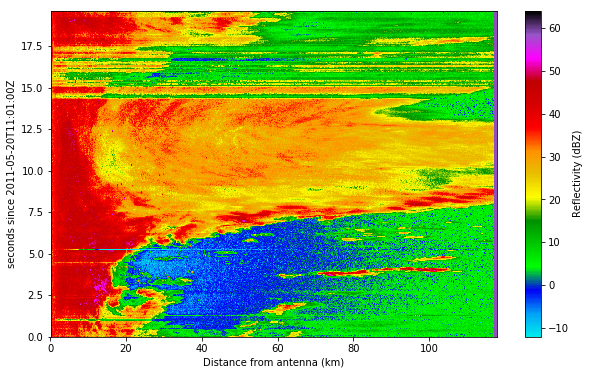

In [10]:
range_array = radar_sweep.range['data']/1000.0
time_array = radar_sweep.time['data']
fig = plt.figure(figsize = [10,6])
plt.pcolormesh(range_array, time_array,
               radar_sweep.fields['reflectivity']['data'],
               cmap = pyart.graph.cm.NWSRef,
               vmin = -12, vmax = 64)
plt.ylabel(radar_sweep.time['units'])
plt.xlabel('Distance from antenna (km)')
plt.colorbar(label = 'Reflectivity (dBZ)')

Pre-Packaged plotting tools
-------------------------
Py-ART has a number of plotting utilities contained within the graph module. This includes plotting PPIs (constant elevation scans), RHIs (constant azimuth scans) and line plots along rays. In addition it can plot both radial and cartesian data on maps using Matplotlib's Basemap module and (New and experimental) Cartopy.

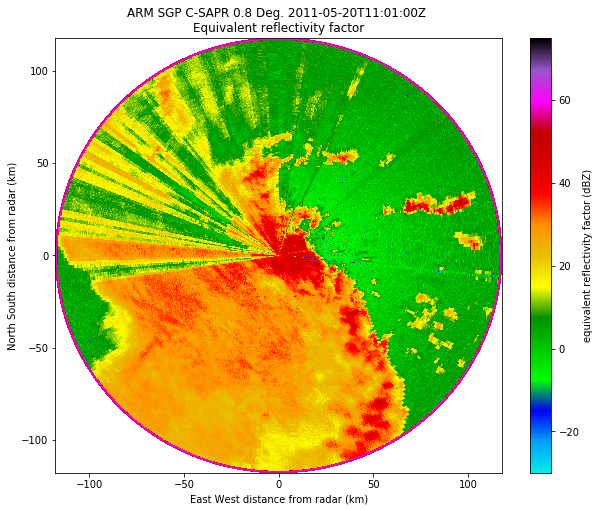

In [11]:
#plotting data from a PPI

#Set up a Matplotlib figure
my_figure = plt.figure(figsize = [10,8])

#Set up a Py-ART display instance
my_display = pyart.graph.RadarDisplay(radar)

#plot a ppi of the data
my_display.plot_ppi('reflectivity', 0)

Task
----
* Change colormap
* change vmin/vmax
* plot radial velocity

Plotting on a map using Basemap
-----------------------------
Warning, Basemap will be depricated in 2020

/Users/scollis/anaconda/envs/ams-workshop/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3435: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/scollis/anaconda/envs/ams-workshop/lib/python3.5/site-packages/mpl_toolkits/basemap/__init__.py:3444: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


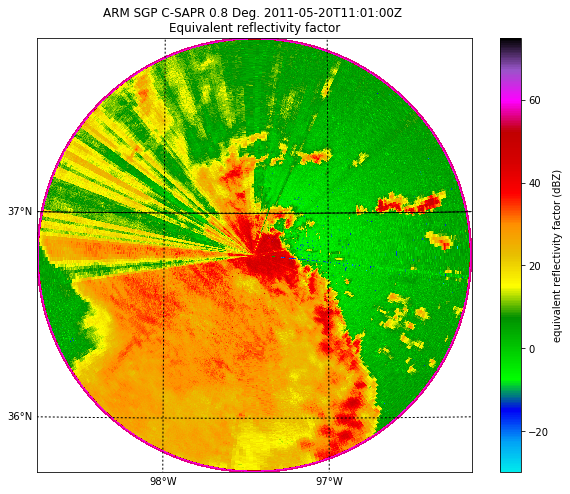

In [12]:
#plotting data from a PPI on a map

#Set up a Matplotlib figure
my_figure = plt.figure(figsize = [10,8])

#Set up a Py-ART map display instance
my_display = pyart.graph.RadarMapDisplay(radar) #Note Map!

#plot a ppi of the data
my_display.plot_ppi_map('reflectivity', 0, resolution = 'c')

Plotting on a map using Cartopy
-----------------------------
Cartopy is a less mature but growing codebase

/Users/scollis/anaconda/envs/ams-workshop/lib/python3.5/site-packages/matplotlib/ticker.py:1693: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


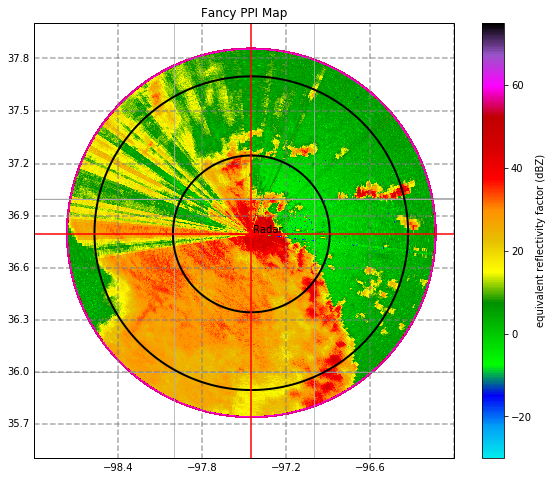

In [13]:
fig = plt.figure(figsize = [10,8])
display = pyart.graph.RadarMapDisplayCartopy(radar)
lat_0 = display.loc[0]
lon_0 = display.loc[1]

#Main difference! Cartopy forces you to select a projection first!
projection = cartopy.crs.Mercator(
                central_longitude=lon_0,
                min_latitude=33.0, max_latitude=38.)

display.plot_ppi_map(
    'reflectivity', 0, colorbar_flag=True,
    title="Fancy PPI Map",
    projection=projection,
    min_lon=-99, max_lon=-96, min_lat=35.5, max_lat=38,
    mask_outside=True)

#Mark the radar
display.plot_point(lon_0, lat_0, label_text='Radar')

#Range rings
display.plot_range_rings([50, 100])

#Cross hairs
display.plot_line_geo(np.array([lon_0, lon_0]), np.array([35.5, 38]))
display.plot_line_geo(np.array([-99, -96]), np.array([lat_0, lat_0]))

#Get the current axes and plot some lat and lon lines
ax = plt.gca()
gl = ax.gridlines( draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
